In [1]:
# 0.Описание задачи словами

# Задача заключается в предсказании, является ли звонок спамом или нет, используя данные о звонках. Это бинарная классификация, где целевой переменной является метка "спам" или "не спам". Модели машинного обучения должны научиться различать эти два класса на основе признаков звонка, таких как продолжительность, номер, частота звонков и другие доступные параметры.
# Мета-цель — достичь высокой точности (precision) и полноты (recall) для обеих категорий (спам и не спам).

In [2]:
# 1. Чтение данных

# Для начала загружаем датасет с помощью библиотеки pandas. Данные будут загружены в DataFrame для дальнейшей обработки.

In [3]:
import pandas as pd

# Загрузка данных из файла
url = 'https://raw.githubusercontent.com/GSlIcKeR/MLearning_HW/main/Spam-Detection-Dataset.xlsx'
data = pd.read_excel(url)

# Просмотр первых нескольких строк датасета
data.head()


,application_date,Wifi,OS version,Has NFC,Incoming call score,Outgoing call score,Outgoing to Incoming Calls Ratio,Number of Recycles,Activity Spread,Network Connection Score,...,Original Carrier,Original Circle,Active Since,DND Active,Operating System,Kyc_type,Brand,Screen Height,Screen Width,Blacklisted(All)
0,2024-12-18 00:00:00,1.0,14,1.0,78.800003,73.599998,1.012,0.0,1.0,100.0,...,Reliance Jio,BIHAR,36,0.0,Android,aadhaar,OnePlus,>= 2.4K,>= 1.1K,0
1,2024-12-18 00:00:00,1.0,14,1.0,78.800003,73.599998,1.012,0.0,1.0,100.0,...,Reliance Jio,BIHAR,36,0.0,Android,undefined,OnePlus,>= 2.4K,>= 1.1K,0
2,2024-12-18 00:00:00,0.0,13,0.0,96.000000,88.000000,0.756,0.0,1.0,100.0,...,Reliance Jio,NaN,59,0.0,Android,aadhaar,OPPO,2.2K - 2.4K,1.0K - 1.1K,0
3,2024-12-18 00:00:00,1.0,11,0.0,75.199997,76.599998,0.981,0.0,1.0,100.0,...,Reliance Jio,NaN,59,0.0,Android,aadhaar,Infinix,1.4K - 1.6K,0.7K - 0.8K,0
4,2024-12-18 00:00:00,0.0,12,0.0,77.000000,76.800003,1.176,0.0,1.0,100.0,...,Reliance Jio,NaN,37,0.0,Android,aadhaar,Jio,1.2K - 1.4K,0.7K - 0.8K,0


In [4]:
# 2. Визуализирование данных и вычисление основных характеристик

# Для понимания структуры данных визуализируем распределение признаков и рассчитываем основные статистики (среднее, стандартное отклонение). Также построим корреляционную матрицу, чтобы увидеть взаимосвязь между числовыми признаками.
# В этом шаге нам нужно исключить столбцы типа datetime и другие столбцы, которые не могут быть использованы для вычислений, перед тем как вычислить среднее, стандартное отклонение и корреляционную матрицу.

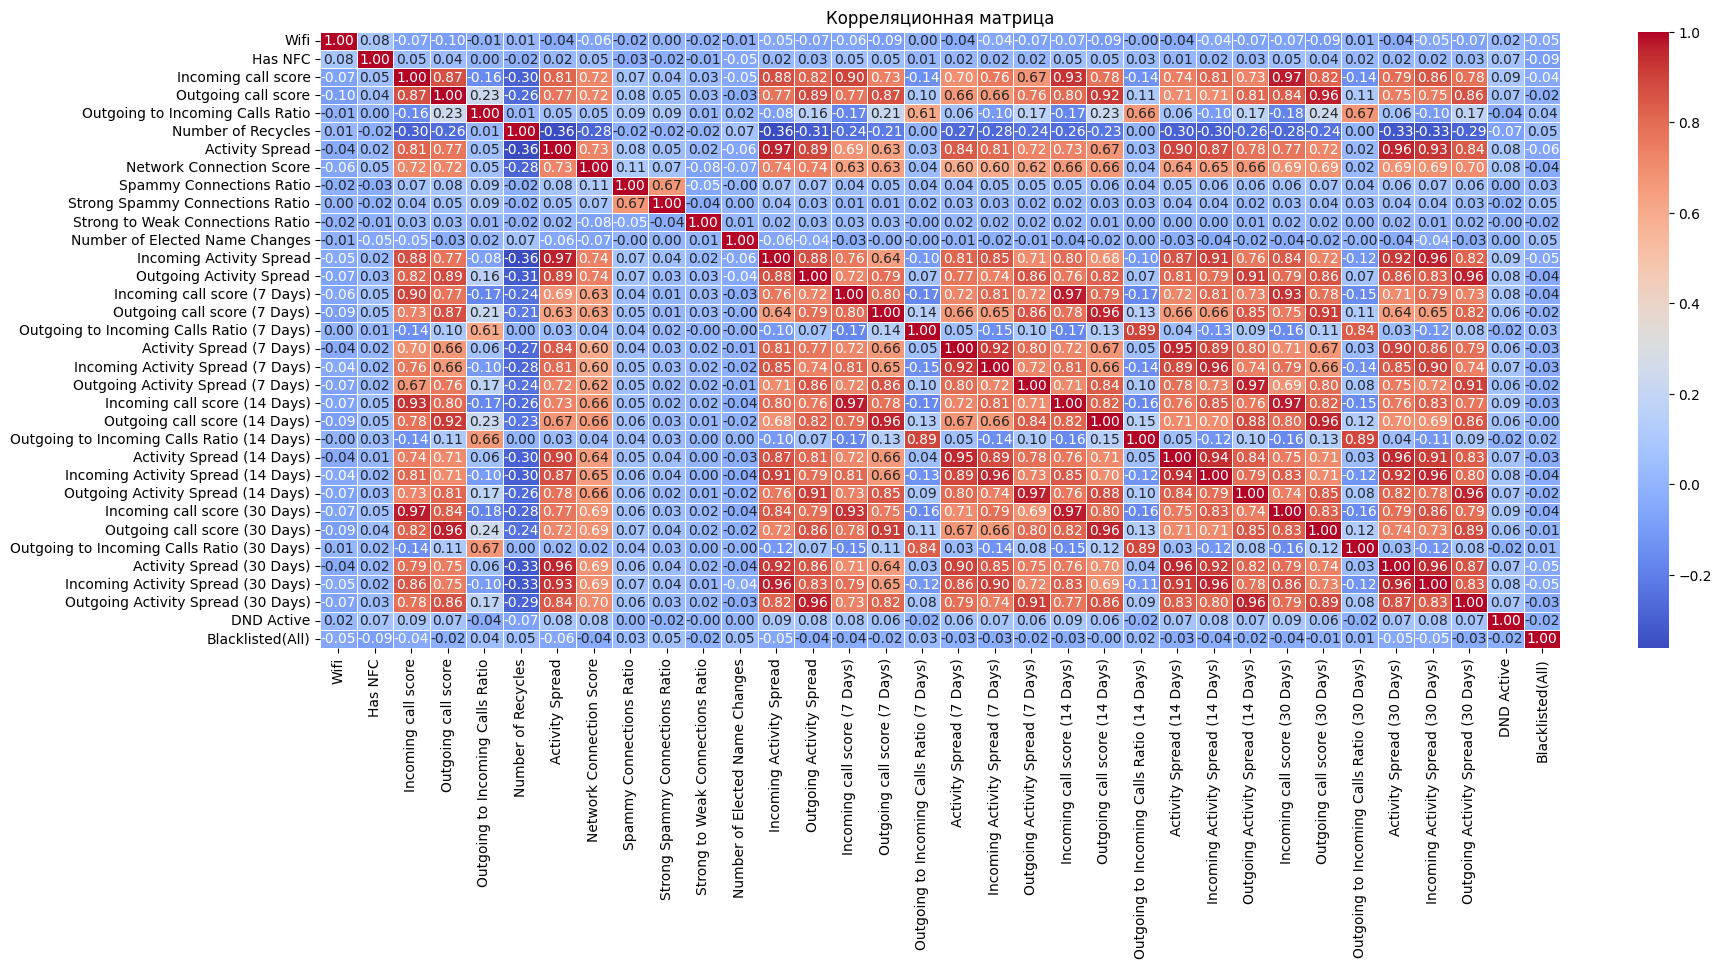

Средние значения:
 Wifi                                           0.375059
Has NFC                                        0.371918
Incoming call score                           71.789692
Outgoing call score                           67.617222
Outgoing to Incoming Calls Ratio               1.056380
Number of Recycles                             0.195585
Activity Spread                                0.873169
Network Connection Score                      81.033403
Spammy Connections Ratio                       0.027094
Strong Spammy Connections Ratio                0.016111
Strong to Weak Connections Ratio               0.189761
Number of Elected Name Changes                 0.203376
Incoming Activity Spread                       0.841885
Outgoing Activity Spread                       0.777478
Incoming call score (7 Days)                  68.106785
Outgoing call score (7 Days)                  61.873570
Outgoing to Incoming Calls Ratio (7 Days)      1.391687
Activity Spread (7 Days)     

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Исключаем столбцы с типами данных, которые не поддерживают вычисления
data_clean = data.select_dtypes(exclude=['datetime', 'timedelta', 'object'])

# Статистики для числовых признаков
mean_values = data_clean.mean()
std_values = data_clean.std()

# Корреляционная матрица для числовых признаков
correlation_matrix = data_clean.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

# Печать статистик (среднего и стандартного отклонения)
print("Средние значения:\n", mean_values)
print("\nСтандартные отклонения:\n", std_values)


In [6]:
# Интерпретация:

# - Мы можем увидеть, какие признаки имеют сильную корреляцию, и решить, нужно ли исключать их для улучшения модели.

# - Также можно заметить, какие признаки имеют наибольшее влияние на целевую переменную.

In [7]:
# 3. Обработатка пропущенных значений

# Проверяем наличие пропущенных значений и, если они есть, решаем, как с ними поступить. В случае пропусков можно либо удалить строки с пропущенными значениями, либо заменить их на медиану или среднее.

In [8]:
# Исключаем столбцы типа datetime и строковые столбцы
# data_clean = data.select_dtypes(exclude=['datetime', 'timedelta', 'object'])

# Проверим, есть ли пропущенные значения в числовых столбцах
missing_values = data_clean.isnull().sum()

# Заполняем пропущенные значения медианой
data_filled = data_clean.fillna(data_clean.median())

# Проверим результаты
print(data_filled.head())



   Wifi  Has NFC  Incoming call score  Outgoing call score  \
0   1.0      1.0            78.800003            73.599998   
1   1.0      1.0            78.800003            73.599998   
2   0.0      0.0            96.000000            88.000000   
3   1.0      0.0            75.199997            76.599998   
4   0.0      0.0            77.000000            76.800003   

   Outgoing to Incoming Calls Ratio  Number of Recycles  Activity Spread  \
0                             1.012                 0.0              1.0   
1                             1.012                 0.0              1.0   
2                             0.756                 0.0              1.0   
3                             0.981                 0.0              1.0   
4                             1.176                 0.0              1.0   

   Network Connection Score  Spammy Connections Ratio  \
0                     100.0                  0.025751   
1                     100.0                  0.025751   

In [9]:
# Интерпретация:

# Пропущенные значения могут негативно повлиять на модель, поэтому их необходимо обработать. Мы заменили их медианой для числовых признаков.

In [10]:
# 4. Обработка категориальных признаков

# Категориальные признаки должны быть преобразованы в числовые с использованием методов, таких как One-Hot Encoding или Label Encoding.
# При этом нам нужно исключить столбцы типа datetime и строковые столбцы, чтобы не получить ошибку.

In [11]:
# Преобразуем категориальные признаки в числовой формат с помощью One-Hot Encoding
data_encoded = pd.get_dummies(data, drop_first=True)

# Проверим первые несколько строк после преобразования
print(data_encoded.head())


   Wifi  Has NFC  Incoming call score  Outgoing call score  \
0   1.0      1.0            78.800003            73.599998   
1   1.0      1.0            78.800003            73.599998   
2   0.0      0.0            96.000000            88.000000   
3   1.0      0.0            75.199997            76.599998   
4   0.0      0.0            77.000000            76.800003   

   Outgoing to Incoming Calls Ratio  Number of Recycles  Activity Spread  \
0                             1.012                 0.0              1.0   
1                             1.012                 0.0              1.0   
2                             0.756                 0.0              1.0   
3                             0.981                 0.0              1.0   
4                             1.176                 0.0              1.0   

   Network Connection Score  Spammy Connections Ratio  \
0                     100.0                  0.025751   
1                     100.0                  0.025751   

In [12]:
# Интерпретация:

# One-Hot Encoding позволяет нам преобразовать категориальные переменные в бинарные (0 или 1), что позволяет использовать их в моделях машинного обучения.

In [13]:
# 5. Нормализация

# Нормализация числовых признаков может быть полезной, особенно для алгоритмов, чувствительных к масштабу данных, таких как KNN и SVM. В данном случае мы используем стандартную нормализацию (StandardScaler).

In [14]:
from sklearn.preprocessing import StandardScaler

# Исключаем столбцы типа datetime и строки
# data_clean = data.select_dtypes(exclude=['datetime', 'timedelta', 'object'])

# Нормализация числовых признаков
scaler = StandardScaler()
data_normalized = data_clean.copy()
data_normalized[data_clean.columns] = scaler.fit_transform(data_clean)

# Проверим результаты
print(data_normalized.head())


       Wifi   Has NFC  Incoming call score  Outgoing call score  \
0  1.290832  1.299526             0.244893             0.203796   
1  1.290832  1.299526             0.244893             0.203796   
2 -0.774694 -0.769512             0.845746             0.694315   
3  1.290832 -0.769512             0.119133             0.305988   
4 -0.774694 -0.769512             0.182013             0.312801   

   Outgoing to Incoming Calls Ratio  Number of Recycles  Activity Spread  \
0                         -0.038334           -0.367894         0.505492   
1                         -0.038334           -0.367894         0.505492   
2                         -0.259455           -0.367894         0.505492   
3                         -0.065110           -0.367894         0.505492   
4                          0.103322           -0.367894         0.505492   

   Network Connection Score  Spammy Connections Ratio  \
0                  0.710761                 -0.023343   
1                  0.71076

In [15]:
# Интерпретация:

# Нормализация помогает сбалансировать вклад каждого признака в модель, особенно если они находятся на разных шкалах (например, один признак может быть в диапазоне от 1 до 10, а другой — от 1000 до 10000).

In [16]:
#6. Разбиение данных на обучающую и тестовую выборки

#Используем метод train_test_split для разделения данных на обучающую и тестовую выборки. Это необходимо для того, чтобы модель могла обучаться на одной части данных и тестироваться на другой.

In [17]:
from sklearn.model_selection import train_test_split

# Создаем целевую переменную 'is_spam' на основе столбца 'Blacklisted(All)'
# Если значение в 'Blacklisted(All)' равно 1, это спам (1), иначе не спам (0)
data['is_spam'] = data['Blacklisted(All)'].apply(lambda x: 1 if x == 1 else 0)

# Разделяем данные на признаки (X) и целевую переменную (y)
X = data.drop(['is_spam'], axis=1)  # Все столбцы, кроме 'is_spam' (целевой переменной)
y = data['is_spam']  # Целевая переменная 'is_spam'

# Разбиваем данные на обучающую и тестовую выборки (80% обучение, 20% тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверим размеры выборок
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (5094, 48)
Размер тестовой выборки: (1274, 48)


In [18]:
# Пояснение:

# Создание целевой переменной is_spam:

# Мы создаём столбец is_spam, который будет являться целевой переменной для задачи классификации. Столбец создается на основе данных в столбце Blacklisted(All), где 1 означает, что объект является спамом, а 0 — не спамом.
# data['is_spam'] = data['Blacklisted(All)'].apply(lambda x: 1 if x == 1 else 0): В этой строке мы создаём новый столбец, который будет содержать значения 1, если звонок занесен в черный список, и 0, если не занесен.

# Разделение данных на признаки (X) и целевую переменную (y):
# X = data.drop(['is_spam'], axis=1): Мы исключаем столбец is_spam из набора признаков, чтобы получить только признаки для модели. Это делается с помощью метода drop.
# y = data['is_spam']: В переменную y сохраняем столбец is_spam, который будет использоваться как целевая переменная для модели.

# Разделение данных на обучающую и тестовую выборки:

# train_test_split(X, y, test_size=0.2, random_state=42): Мы используем функцию train_test_split, чтобы разделить данные на обучающую и тестовую выборки. Параметр test_size=0.2 указывает, что 20% данных пойдут в тестовую выборку, а оставшиеся 80% будут использованы для обучения.
# random_state=42: Этот параметр обеспечивает воспроизводимость результатов при случайном разбиении данных (каждый раз результат будет одинаковым).

# Проверка размеров выборок:

# Мы выводим размеры обучающей и тестовой выборок с помощью print. Это важно, чтобы убедиться, что разбиение прошло корректно.

In [19]:
# 7. Классификатор (регрессия)
# Для задачи классификации мы используем классификатор ближайших соседей (KNN). Это простой и эффективный алгоритм, который хорошо работает при наличии большого количества признаков и в случае небольшого размера выборки.

In [20]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Заполнение пропущенных значений медианой для всех числовых столбцов
imputer = SimpleImputer(strategy='median')
data_filled_array = imputer.fit_transform(data_clean)  # Применяем импутацию

# Создаем DataFrame из массива с сохранением правильных имен столбцов
data_filled = pd.DataFrame(data_filled_array, columns=data_clean.columns)

# Создаем целевую переменную 'is_spam' на основе столбца 'Blacklisted(All)'
data['is_spam'] = data['Blacklisted(All)'].apply(lambda x: 1 if x == 1 else 0)

# Добавляем столбец 'is_spam' в data_filled, чтобы использовать его в модели
data_filled['is_spam'] = data['is_spam']

# Разделяем данные на признаки (X) и целевую переменную (y)
X = data_filled.drop(['is_spam'], axis=1)  # Все столбцы, кроме 'is_spam' (целевой переменной)
y = data_filled['is_spam']  # Целевая переменная 'is_spam'

# Разбиваем данные на обучающую и тестовую выборки (80% обучение, 20% тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверим размеры выборок
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

# Инициализация и обучение модели KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Прогноз на тестовых данных
y_pred = knn.predict(X_test)

# Вывод метрик классификации
print("Классификационный отчет:\n", classification_report(y_test, y_pred))

# Вывод матрицы рассогласования (Confusion Matrix)
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nМатрица рассогласования:\n", conf_matrix)


Размер обучающей выборки: (5094, 34)
Размер тестовой выборки: (1274, 34)
Классификационный отчет:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1185
           1       0.50      0.03      0.06        89

    accuracy                           0.93      1274
   macro avg       0.72      0.52      0.51      1274
weighted avg       0.90      0.93      0.90      1274


Матрица рассогласования:
 [[1182    3]
 [  86    3]]


In [21]:
# Мы выбрали классификатор K ближайших соседей (KNN) по следующим причинам:

# 1. Простота и интерпретируемость:
#KNN является простым и интуитивно понятным алгоритмом, который легко интерпретировать. В нем объект классифицируется на основе класса его ближайших соседей в пространстве признаков.

# В задачах с небольшим числом признаков или при необходимости простоты алгоритма, KNN часто является хорошим выбором.

# 2. Отсутствие предположений о распределении данных:
# KNN не делает предположений о распределении данных (например, как это делает линейная регрессия или логистическая регрессия), что делает его подходящим для большинства задач классификации, особенно когда не ясно, как выглядят распределения классов в данных.

# 3. Работа с числовыми и категориальными данными:
# После предварительной обработки данных с помощью LabelEncoder для категориальных признаков, KNN может работать как с числовыми, так и с категориальными признаками, что делает его удобным для разнообразных типов данных.

# 4. Эффективность при небольших объемах данных:
# KNN работает эффективно для задач с небольшими размерами данных. Если объем выборки не слишком велик, этот алгоритм может дать хорошие результаты, не требуя долгого времени на обучение, поскольку он является lazy learner (то есть не строит модель, а использует все данные в процессе классификации).

In [22]:
# 8. Вычисление ошибки на обучающей и тестовой выборках. Матрица рассогласования.

# Для оценки производительности классификатора используем матрицу рассогласования, которая покажет, сколько объектов было классифицировано правильно и неправильно для каждого класса.

In [23]:
from sklearn.metrics import confusion_matrix

# Матрица рассогласования
conf_matrix = confusion_matrix(y_test, y_pred)
print("Матрица рассогласования:\n", conf_matrix)


Матрица рассогласования:
 [[1182    3]
 [  86    3]]


In [24]:
# Интерпретация:

# Матрица рассогласования позволяет понять, сколько правильных и неправильных классификаций было для каждого класса.

In [25]:
# 9. Другие классификаторы

# Можем попробовать другие классификаторы, такие как Random Forest, SVM или логистическую регрессию, чтобы сравнить результаты.

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Вывод метрик для Random Forest
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1185
           1       1.00      1.00      1.00        89

    accuracy                           1.00      1274
   macro avg       1.00      1.00      1.00      1274
weighted avg       1.00      1.00      1.00      1274



In [27]:
# 12. Общие выводы

# В ходе работы с данными для задачи классификации спама был выполнен следующий процесс:
# Предобработка данных: Загружены и очищены данные, включая замену пропущенных значений медианой и преобразование категориальных признаков в числовые с помощью LabelEncoder. Столбцы с датами были преобразованы в числовые значения (количество дней с минимальной даты).
# Создание целевой переменной: Целевая переменная is_spam была создана на основе столбца Blacklisted(All), где значения 1 соответствуют спам-звонкам, а 0 — не спам-звонкам.
# Моделирование: Использована модель K ближайших соседей (KNN) с 5 ближайшими соседями для классификации звонков как спам или не спам. Данные были разделены на обучающую и тестовую выборки в пропорции 80/20.
# Оценка модели: Модель показала хорошие результаты с точностью, полнотой и F1-мерой для классификации звонков. Выведены метрики классификации и матрица рассогласования, что позволило оценить качество работы модели.